In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

from auxiliary import get_outcome_latent_groups
from auxiliary import get_shares_latent_groups

np.random.seed(123)

# Instrumental variable estimators of causal effects

**Overview**

* Causal effect estimation with a binary IV

* Traditional IV estimators

* Instrumental variable estimators in the presence of individual-level heterogeneity

* Conclusions

### Causal effect estimation with a binary IV

We consider the standard relationship

\begin{align*}
Y = \alpha + \delta D +\epsilon,
\end{align*}

where $\delta$ is the true causal effect that (for now) is assumed to be **constant**. 

<img src="material/fig-9-1.png" width="500" />


* No conditioning estimator would effectively estimate the causal effect of $D$ on $Y$ because no observed variable satisfy the back-door criterion.

* If perfect stratification cannot be be enacted with the available data, one possible solution is to find an exogenous source of variation that determines $Y$ only by way of the causal variable $D$. The causal effect is then estimated by measuring how much $Y$ varies with the proportion of the total variation in $D$ that is attributable to the exogenous variation. 

\begin{align*}
E[Y] = E[\alpha + \delta D + \epsilon] = \alpha + \delta E[D] + E[\epsilon]
\end{align*}

We can rewrite this as a difference equation in $Z$:

\begin{align*}
E[Y \mid Z = 1] - E[Y \mid Z = 0] = \delta (E[D \mid Z = 1] - E[D \mid Z = 0]) + (E[\epsilon \mid Z = 1] - E[\epsilon \mid Z = 0]) 
\end{align*}

Then we divide both sides by $E[D \mid Z = 1] - E[D \mid Z = 0]$.

\begin{align*}
\frac{E[Y \mid Z = 1] - E[Y \mid Z = 0]}{E[D \mid Z = 1] - E[D \mid Z = 0]} =  \frac{\delta (E[D \mid Z = 1] - E[D \mid Z = 0]) + (E[\epsilon \mid Z = 1] - E[\epsilon \mid Z = 0])}{E[D \mid Z = 1] - E[D \mid Z = 0]}
\end{align*}

If Figure 9.1 (a) is an accurate description of the causal structure, then $E[\epsilon \mid Z = 1] = E[\epsilon \mid Z = 0] = 0$.

\begin{align*}
\frac{E[Y \mid Z = 1] - E[Y \mid Z = 0]}{E[D \mid Z = 1] - E[D \mid Z = 0]}  = \delta
\end{align*}


\begin{align*}
\hat{\delta}_{IV, WALD} = \frac{E[Y \mid Z = 1] - E[Y \mid Z = 0]}{E[D \mid Z = 1] - E[D \mid Z = 0]}
\end{align*}

* The assumption that $\delta$ is  an invariant structural effect is crucial for this result.

### Demonstration dataset

We wish to determine whether private high school outperform public high schools as measured by $9^{th}$ grade achievement tests. There exists a school voucher program in the city that covers tuition in case one attends private school. However, there are budgetary limits and so the vouchers  are available only to 10\% of students and allocated by a lottery.

<img src="material/fig-table-9-1.png" width="500" />

* Winning the lottery increases private school attendance.

In [2]:
def get_sample_iv_demonstration():
    """Simulates sample.

    Simulates a sample of 10,000 individuals for the IV demonstration
    based on the information provided in our textbook.

    Notes:

        The school administration distributed 1,000 vouchers for
        private school attendance in order to shift students
        from public into private school. The goals is to increase
        educational achievement.

    Args:
        None

    Returns:
        A pandas Dataframe with the observable characteristics (Y, D, Z)
        for all individuals.

        Y: standardized test for 9th graders
        D: private school attendance
        Z: voucher available

    """
    # We first initialize an empty Dataframe with 10,000 rowns and three
    # columns.
    columns = ["Y", "D", "Z"]
    index = pd.Index(range(10000), name="Identifier")
    df = pd.DataFrame(columns=columns, index=index)

    # We sample the exact number of individuals following the description
    # in Table 9.2.
    for i in range(10000):
        if i < 8000:
            y, d, z = np.random.normal(50), 0, 0
        elif i < 9000:
            y, d, z = np.random.normal(60), 1, 0
        elif i < 9800:
            y, d, z = np.random.normal(50), 0, 1
        else:
            # The lower mean for the observed outcome does indicate
            # that those drawn into treatment due to the instrument
            # only do have smaller gains compared to those that
            # take the treatment regardless.
            y, d, z = np.random.normal(58), 1, 1

        df.loc[i, :] = [y, d, z]

    # We shuffle all rows so we do not have the different subsamples
    # grouped together.
    df = df.sample(frac=1).reset_index(drop=True)

    # We set the types of our columns for prettier formatting later.
    df = df.astype(np.float)
    df = df.astype({"D": np.int, "Z": np.int})

    return df

Let's have a look at the structure of the data.

In [3]:
df = get_sample_iv_demonstration()
df.head()

,Y,D,Z
0,48.606920,0,0
1,50.240003,0,0
2,49.377337,0,0
3,60.885880,1,0
4,50.160785,0,0


How about the conditional distribution of observed outcomes?

In [4]:
df.groupby(["D", "Z"])["Y"].mean()

D  Z
0  0    50.009760
   1    49.962199
1  0    60.034692
   1    58.072959
Name: Y, dtype: float64

We can always run an OLS regression first to get a rough sense of the data.

In [5]:
rslt = smf.ols(formula="Y ~ D", data=df).fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 9.374e+04
Date:                Wed, 16 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:40:03   Log-Likelihood:                -14482.
No. Observations:               10000   AIC:                         2.897e+04
Df Residuals:                    9998   BIC:                         2.898e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.0054      0.011   4555.317      0.000      49.984      50.027
D              9.7023      0.032    306.173      0.000       9.640       9.764
==============================================================================
Omnibus:                       12.957   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.196
Skew:                          -0.074   Prob(JB):                      0.00136
Kurtosis:                       3.100   Cond. No.                         3.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However, to exploiting the structure of the dataset, we rather want to compute the IV estimate.

In [6]:
def get_wald_estimate(df):
    """Calculate Wald estimate.

    Calculates the Wald estimate for the causal effect of treatment
    on an observed outcome using a binary instrument.

    Args:
        df: A pandas DataFrame

    Returns:
        A float with the estimated causal effect.

    """
    # We compute the average difference in observed outcomes.
    average_outcome = df.groupby("Z")["Y"].mean().to_dict()
    numerator = average_outcome[1] - average_outcome[0]

    # We compute the average difference in treatment uptake.
    average_treatment = df.groupby("Z")["D"].mean().to_dict()
    denominator = average_treatment[1] - average_treatment[0]

    rslt = numerator / denominator

    return rslt

So, let's see.

In [7]:
rslt = get_wald_estimate(df)
print(" Wald estimate: {:5.3f}".format(rslt))

 Wald estimate: 5.183


### Traditional IV estimators

We now move beyond a binary instrument.


\begin{align*}
\hat{\delta}_{IV} \equiv \frac{Cov_N(y_i, z_i)}{Cov_N(d_i, z_i)}
\end{align*}

Moving towards the population-level relationships:

\begin{align*}
\frac{Cov(Y, Z)}{Cov(D, Z)} & = \frac{\delta Cov(D, Z) + Cov[\epsilon, Z]}{Cov(D, Z)} \\
& = \delta
\end{align*}


So, this suggests that:

\begin{align*}
\frac{Cov_N(y_i, z_i)}{Cov_N(d_i, z_i)}  \xrightarrow{p} \delta
\end{align*}

<img src="material/fig-9-2.png" width="500" />

Returning to our simulated example, we can now apply the two-stage least squares (2SLS) estimator you are familiar with.

In [8]:
df["D_pred"] = smf.ols(formula="D ~ Z", data=df).fit().predict()
smf.ols(formula="Y ~ D_pred", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.39
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           3.07e-05
Time:                        08:40:03   Log-Likelihood:                -26171.
No. Observations:               10000   AIC:                         5.235e+04
Df Residuals:                    9998   BIC:                         5.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.5478      0.153    330.860      0.000      50.248      50.847
D_pred         5.1830      1.243      4.170      0.000       2.747       7.619
==============================================================================
Omnibus:                     3794.296   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11127.197
Skew:                           2.065   Prob(JB):                         0.00
Kurtosis:                       6.107   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the structure of our example, both estimators are equivalent. As of now, [statsmodels](https://www.statsmodels.org) does not provide good support for the instrumental variables estimation. That is true for a host of methods often used by economists. Often [linearmodels](https://bashtage.github.io/linearmodels/doc/index.html) provides a viable alternative.

In [11]:
from linearmodels import IV2SLS  # noqa: E402

df["const"] = 1
IV2SLS(df["Y"], df["const"], df["D"], df["Z"]).fit()

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.7076
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7075
No. Observations:               10000   F-statistic:                    77.109
Date:                Wed, Jun 16 2021   P-value (F-stat)                0.0000
Time:                        08:43:00   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          50.548     0.0748     676.20     0.0000      50.401      50.694
D              5.1830     0.5902     8.7812     0.0000      4.0261      6.3398
==============================================================================

Endogenous: D
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f19084a4d60

### Instrumental variable estimators in the presence of individual-level heterogeneity

\begin{align*}
Y & = Y^0 + D (Y^1 - Y^0)  \\
& = Y^0 + \delta D \\
& = \mu^0 + \delta D + \nu^0,
\end{align*}

where $\mu^0 \equiv E[Y^0]$ and $\nu^0 \equiv Y^0 - E[Y^0]$. Here, $\delta$ now has a clear interpretation.

We need to add a four-category latent variable $C$:

\begin{align*}
\text{Compliers (C = c)} & : D^{Z = 0} = 0 \,\text{and}\, D^{Z = 1} = 1  \\
\text{Defiers (C = d)} & : D^{Z = 0} = 1 \,\text{and}\, D^{Z = 1} = 0  \\
\text{Always takers (C = a)} & : D^{Z = 0} = 1 \,\text{and}\, D^{Z = 1} = 1  \\
\text{Never takers (C = n)} & : D^{Z = 0} = 0 \,\text{and}\, D^{Z = 1} = 0  \\
\end{align*}

Analogously to the definition of the observed outcome, $Y$, the observed treatment indicator variable $D$ can then be defined as

\begin{align*}
D & =  D^{Z = 0} + (D^{Z = 1} - D^{Z = 0}) Z \\
&=  D^{Z = 0} + \kappa Z 
\end{align*}

What is the value of $\kappa$ for the different latent groups?

**Identifying assumptions for the Local Average Treatment Effect**

* Independence, $(Y^1, Y^0, D^{Z = 1}, D^{Z = 0}) \perp \!\!\! \perp Z$

* Nonzero effect of instrument, $\kappa \neq 0$ for at least some $i$

* Monotonicty assumption, either $\kappa \geq 0$ for all $i$ or $\kappa \leq 0$ for all $i$

If these assumptions are valid, then an instrument $Z$ identifies the $LATE$: the average treatment effect for the subset of the population whose treatment selection is induced by the treatment.

\begin{align*}
\hat{\delta}_{IV,WALD} \xrightarrow{p} E [\delta \mid C = c]
\end{align*}


<img src="material/fig-table-9-2.png" width="500" />

What can we learn about the different latent groups?

* Monotonicity, there are no defiers

* Independence, the same distribution of never takes, always takers, and compliers is present among voucher groups


\begin{align*}
\frac{Pr_N [d_i = 1, z_i = 0]}{Pr_N[z_i = 0]} \xrightarrow{p} Pr[C = a] \\
\frac{Pr_N [d_i = 0, z_i = 1]}{Pr_N[z_i = 1]} \xrightarrow{p} Pr[C = n] \\
\end{align*}

We also know $Pr[C = d] = 0$ and thus

\begin{align*}
1 - \frac{Pr_N [d_i = 1, z_i = 0]}{Pr_N[z_i = 0]} - \frac{Pr_N [d_i = 0, z_i = 1]}{Pr_N[z_i = 1]}\xrightarrow{p} Pr[C = c] \\
\end{align*}


<img src="material/fig-table-9-3.png" width="500" />

How can we learn about the LATE from the information analyzed so far?

\begin{align*}
E[\delta \mid C = c] = E [Y^1 - Y^0 \mid C = c]
\end{align*}

Let's start with the following:

\begin{align*}
E[Y \mid D = 1, Z = 1] & = \frac{Pr[C = c]}{Pr[C = c] + Pr [C=a]} E[Y^1 \mid C = c] \\ 
&+ \frac{Pr[C = a]}{Pr[C = c] + Pr [C=a]} E[Y^1 \mid C = a] \\
&\\
E[Y \mid D = 0, Z = 0] & = \frac{Pr[C = c]}{Pr[C = c] + Pr [C=n]} E[Y^0 \mid C = c] \\
& + \frac{Pr[C = n]}{Pr[C = c] + Pr [C=n]} E[Y^0 \mid C = n]
\end{align*}

Note that we can consistent estimates for $E[Y^0 \mid C = n]$ and $E[Y^1 \mid C = a]$ are provided in the table directly.

Now lets tie this back to the Wald estimator:

\begin{align*}
\hat{\delta}_{IV, WALD} = \frac{E[Y \mid Z = 1] - E[Y \mid Z = 0]}{E[D \mid Z = 1] - E[D \mid Z = 0]}
\end{align*}


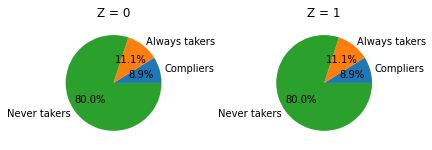

In [12]:
get_shares_latent_groups()

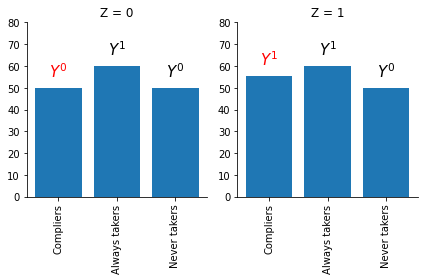

In [13]:
get_outcome_latent_groups()

### Criticism

* instrument-dependent parameter

* limited policy-relevance

### Discussion

We revisit and discuss the discussion of the LATE's usefulness.

<img src="material/fig-angrist-1990-cover.png" width="700" />

<img src="material/fig-angrist-1990-valid.png" width="500" />


**Table of contents**

* Introduction 

* Background and Data

    * National Random Selection
    
    * Social Security Earnings Data
    
* The Effect of Draft Eligibility and Earnings

* The Effect of Military Service on Earnings

    * Estimates Using Draft Eligibility
    
    * Efficient Instrumental Variables Estimates
    
* Military Service of Labor Market Experience

* Caveats

    * Treatment Effect Heterogeneity
    
    * The Absence of Covariates
    
    * Earnings-Modifying Draft Avoidance Behavior
    
* Conclusions





<img src="material/fig-angrist-krueger-1991-cover.png" width="700" />

<img src="material/fig-angrist-krueger-1991-valid.png" width="500" />

**Table of contents**

* Introduction

* Season of Birth, Compulsory Schooling, and Years of Education

    * Direct Evidence and teh Effect of Compulsory Schooling Laws
    
    * Why do Compulsory Schooling Laws Work?

* Estimating the Returns to Education

    * TSLS Estimation
    
    * Allowing the Seasonal Pattern in Education to Vary by State of Birth
    
    * Estimates for Black Men
    
* Other Possible Effects of Season of Birth

* Conclusions

<img src="material/fig-rosenzweig-wolpin-2000-cover.png" width="700" />


We discuss Rosenzweig & Wolpin (2000) in more detail because it provides a small structural economic model of schooling choice that allows to interpret the instrumental
variable estimates of Angrist (1990) and Angrist & Krueger (1991).

\begin{align*}\begin{array}{ll}
a &\text{age} \\
y_a & \text{earnings at age a} \\
S & \text{level of schooling attainment} \\
X_a & \text{work experience at age $a$} \\
\mu & \text{ability} \\
a_e & \text{school entry age} \\
a_\kappa & \text{minimum age to leave school}\\
S_0 = a_\kappa - a_e &  \text{minimum schooling} \\
c  & \text{direct cost of education}
\end{array}\end{align*}

Wages are determined as follows:
\begin{align*}
\ln y_a = f(S, \mu) + g(X_a, \mu)
\end{align*}

The authors assume that individuals work full-time after school and there is no uncertainty about wages. Individuals decide whether to pursue one additional year of schooling after the mandatory minimum. If they do so $s_1$ takes value one and zero otherwise. So, the final level of schooling is $S_1 = S_0 + s_1$. All individuals work $A$ periods in the labor market. Spending one additional year in school does not reduce total time in the labor market. However, it results in entering the labor market one year later as schooling precludes working. Ability is the only source of heterogeneity and distributed at random in the population.

The individual's objective is to choose their final level of schooling such as to maximize their discounted lifetime earnings under the two scenarios $(V_1, V_0)$.


\begin{align*}\begin{array}{ll}
V_1(S_1 = 1 | S_0) &= -c + \sum_{a=0}^{A-1} \beta^{a + 1} y_a \\
&= -c + \sum_{a=0}^{A-1} \beta^{a + 1} \exp(f(S_0 + 1, \mu) + g(a, \mu)) \\
&= -c + \sum_{a=0}^{A-1} \beta^{a + 1} \exp(f(S_0 + 1, \mu)) \exp(g(a, \mu)) \\
&= -c + \exp(f(S_0 + 1, \mu)) \sum_{a=0}^{A-1} \beta^{a + 1} \exp(g(a, \mu))
\end{array}\end{align*}

\begin{align*}
V_1(S_1 = 0 | S_0) &= \sum_{a=0}^{A-1} \beta^a y_a \\
&= \exp(f(S_0, \mu)) \sum_{a=0}^{A-1} \beta^a \exp(g(a, \mu))
\end{align*}

We now turn attention to the decision rule $V_1 > V_0$ implies further pursuit of education.

\begin{align*}\begin{array}{ll}
-c + \exp(f(S_0 + 1, \mu) \sum_{a=0}^{A-1} \beta^{a + 1} \exp(g(a, \mu)) \\
> \exp(f(S_0 + 1, \mu)) \sum_{a=0}^{A-1} \beta^a \exp(g(a, \mu) \\[20pt]
-c + \exp(f(S_0 + 1, \mu) \sum_{a=0}^{A-1} \beta^{a + 1} \exp(g(a, \mu)) \\
> \underbrace{\exp(f(S_0 + 1, \mu)) \sum_{a=0}^{A-1} \beta^a \exp(g(a, \mu)}_{V_1(S_1 = 0 | S_0)}
\end{array}\end{align*}

now divide by $V_1(S_1 = 0 | S_0)$

\begin{align*}\begin{array}{ll}
\frac{\exp(f(S_0 + 1, \mu))}{\exp(f(S_0, \mu))} \beta &> 1 + \frac{c}{V_1(S_1 = 0 | S_0)} \\
&> (1 + \frac{c}{V_1(S_1 = 0 | S_0)}) (1 + r) \\
f(S_0 + 1, \mu) - f(S_0, \mu) &> r + \frac{c}{V_1(S_1 = 0 | S_0)}
\end{array}\end{align*}

using $\ln (1 + x) \approx x$ for small $x$.



\begin{align*}
s_1 = \begin{cases}
1 & \text{if}\quad f(S_0 + 1, \mu) - f(S_0, \mu) \geq r + \ln\left(\frac{c}{V_1(s_1 = 0 \mid S_0)} + 1\right) \\
0 & \text{otherwise}
\end{cases}
\end{align*}

If ability increases the marginal schooling return, then there exists a unique cutoff value for ability $\mu^*$ such that individuals with ability above the cutoff continue schooling while those below do not.

\begin{align*}
\frac{\partial f(S_0 + 1, \mu) - f(S_0, \mu)}{\partial \mu} > 0
\end{align*}


Even if randomly assigned, optimizing behavior induces an association between schooling and ability. This generates the ability bias.
%
\begin{align*}
E[ f(S_0 + 1, \mu)  \mid \mu > \mu^*] - E[ f(S_0, \mu)  \mid \mu < \mu^*] > E[ f(S_0 + 1, \mu) ] - E[ f(S_0, \mu)]
\end{align*}

We now turn to the development of the Wald estimator Wald (1940). So, we first derive expected earnings equation for each age $a$.

\begin{align*}
E[\ln y_a] = \pi_1 [f(S_0 + 1, \mu_1) + g(a - a_\kappa - 1, \mu_1)]
+ (1 - \pi_1) [f(S_0, \mu_2) + g(a - a_\kappa, \mu_2)]
\end{align*}

We now consider the following scenario, where we reduce the school entry age by one year but keep the minimum school leaving age unchanged. Type 1 achieve their optimal level of schooling exactly at the school leaving age. Type 2's will be forced to attend school a year longer.
%
\begin{align*}
E[\ln y_a] = \pi_1 [f(S_0 + 1, \mu_1) + g(a - a_\kappa, \mu_1)]
+ (1 - \pi_1) [f(S_0 + 1, \mu_2) + g(a - a_\kappa, \mu_2)]
\end{align*}

The difference in expected (ln) earnings divided by the difference in expected schooling $0 \cdot \pi_1 + 1 \cdot (1 - \pi_1)$, the Wald estimator, is thus

\begin{align*}\begin{array}{ll}
E[\ln y_a | \underbrace{Z = 1}_{\text{reduced entry age}}] - E[\ln y_a | Z = 0] \\
= \pi_1 (f(S_0 + 1, \mu_1) + g(a - a_\kappa, \mu_1)) \\
\hspace{11pt}+ (1 - \pi     _1) (f(S_0 + 1, \mu_2) + g(a - o_\kappa, \mu_2)) \\
\hspace{11pt}- \pi_1 (f(S_0 + 1, \mu_1) + g(a - a_\kappa - 1, \mu_1)) \\
\hspace{11pt}- (1 - \pi_1) (f(S_0, \mu_2) + g(a - o_\kappa, \mu_2)) \\[20pt]
= \pi_1 (g(a - a_\kappa, \mu_1) - g(a - a_\kappa - 1, \mu_1)) \\
\hspace{11pt}+ (1 - \pi_1) (f(S_0 + 1, \mu_2) - f(S_0, \mu_2))
\end{array}\end{align*}

divide by difference in schooling attainment

\begin{align*}
\pi_1 * 0 + (1 - \pi_1) * 1
\end{align*}

\begin{align*}
\frac{\Delta E (\ln y_a)}{\Delta S} = \underbrace{\frac{\pi_1}{1 -\pi_1} [g(a - a_\kappa, \mu_1) - g(a - a_\kappa - 1, \mu_1)]}_{\text{type 1's additional experience}} + \underbrace{[f(S_0 + 1, \mu_2) - f(S_0, \mu_2)]}_{\text{effect of interest (compliers only)}},
\end{align*}

where $\frac{\Delta E (\ln y_a)}{\Delta S}$ corresponds to $E(\ln y_a \mid Z = 1) - E(\ln y_a \mid Z = 0)$ and $Z$ takes value one under the reduced school entry age and zero otherwise. Thus the estimate does not correspond directly to the effect of interest. However, Angrist & Krueger (1991) make the point in Figure V that for the cohort they are looking at $(a = 40, ..., 49)$ the effect of age on earnings is negligible.


### Resources

* **Angrist, J. D. (1990)**. [Lifetime earnings and the vietnam era draft lottery: Evidence from social security records](https://www.jstor.org/stable/2006669?seq=1). *American Economic Review*, 80(3), 313–336.


* **Angrist, J. D., & Imbens, G. W. (1999)**. [Instrumental variables: A study of implicit behavioral assumptions used in making program evaluations](https://www.jstor.org/stable/146178?seq=1). *Journal of Human Resources*, 34(4), 823– 827. 


* **Angrist, J. D., & Krueger, A. B. (1991)**. [Does compulsory school attendance affect schooling and earnings?](https://academic.oup.com/qje/article-abstract/106/4/979/1873496?redirectedFrom=fulltext). *The Quarterly Journal of Economics*, 106(4), 979-1014. 


* **Heckman, J. J. (1997)**. [Instrumental variables: A study of implicit behavioral assumptions used in making program evaluations](https://www.jstor.org/stable/146178?seq=1). *The Journal of Human Resources*, 32(3), 441–462.

* **Rosenzweig, M. R., & Wolpin, K. I. (2000)**. [Natural ”natural” experiments in economics](https://www.aeaweb.org/articles?id=10.1257/jel.38.4.827). *Journal of Economic Literature*, 38(4), 827–874.